## Using Auto-regressive model

* Steps to choose auto-regressive model

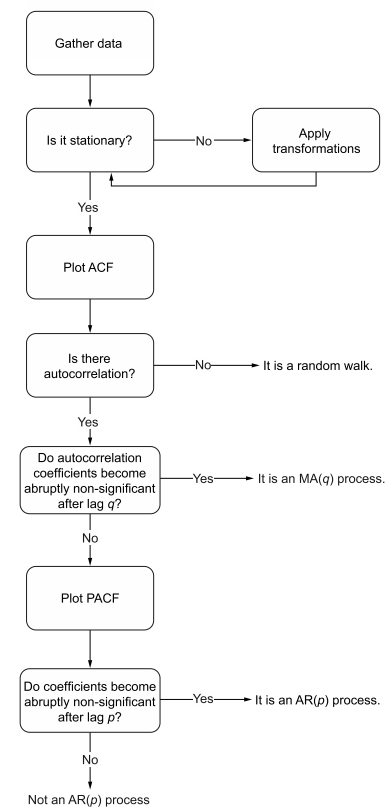

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('foot_traffic.csv')
df

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695
...,...
995,706.009031
996,705.610549
997,704.771335
998,703.559920


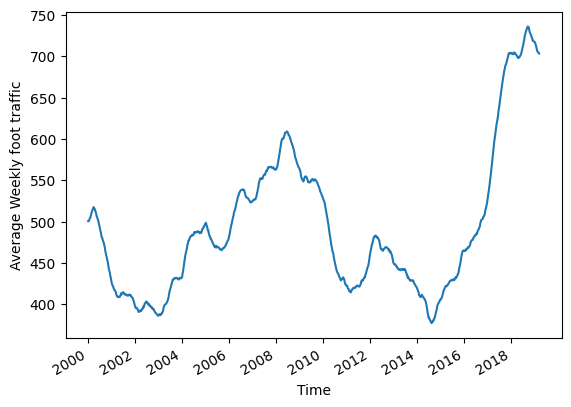

In [3]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average Weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()

In [4]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(df['foot_traffic'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.1758885999240747
p-value: 0.683880891789619


In [5]:
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)

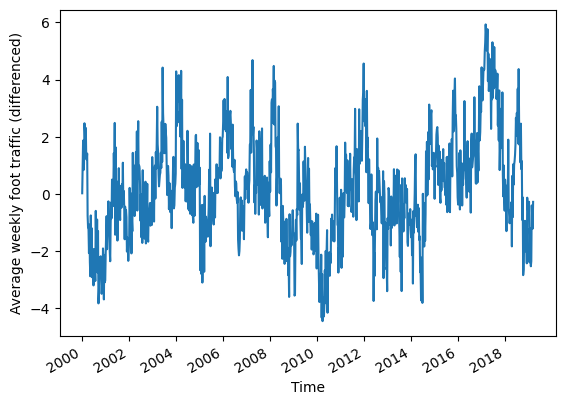

In [6]:
fig, ax = plt.subplots()

ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic (differenced)')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()

In [7]:
ADF_result = adfuller(foot_traffic_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.268231347422044
p-value: 6.369317654781239e-06


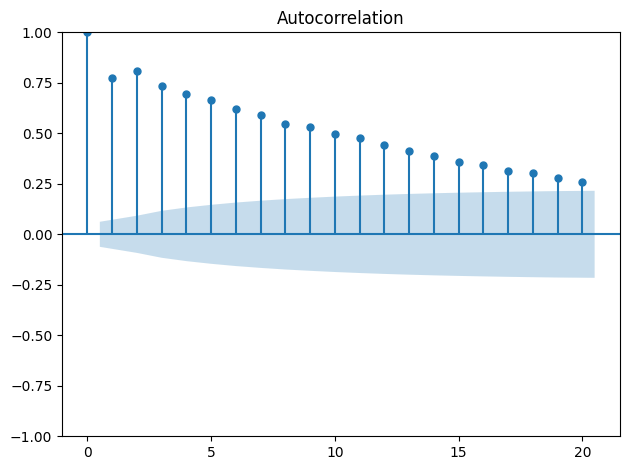

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(foot_traffic_diff, lags=20)

plt.tight_layout()

* This shows that the series is not a moving average process as the autocorrelation coefficients are constantly decaying, it is a auto-regressive process

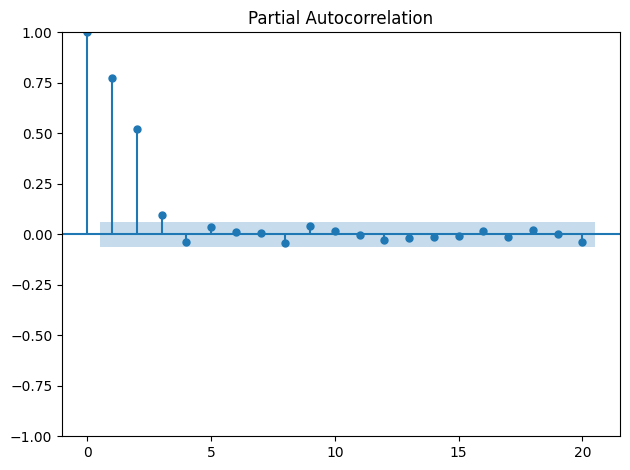

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(foot_traffic_diff, lags=20)
plt.tight_layout()

* The plot suggests that this is an AR(3) process

In [12]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})

train = df_diff[:-52]
test = df_diff[-52:]

print(len(train))
print(len(test))

947
52


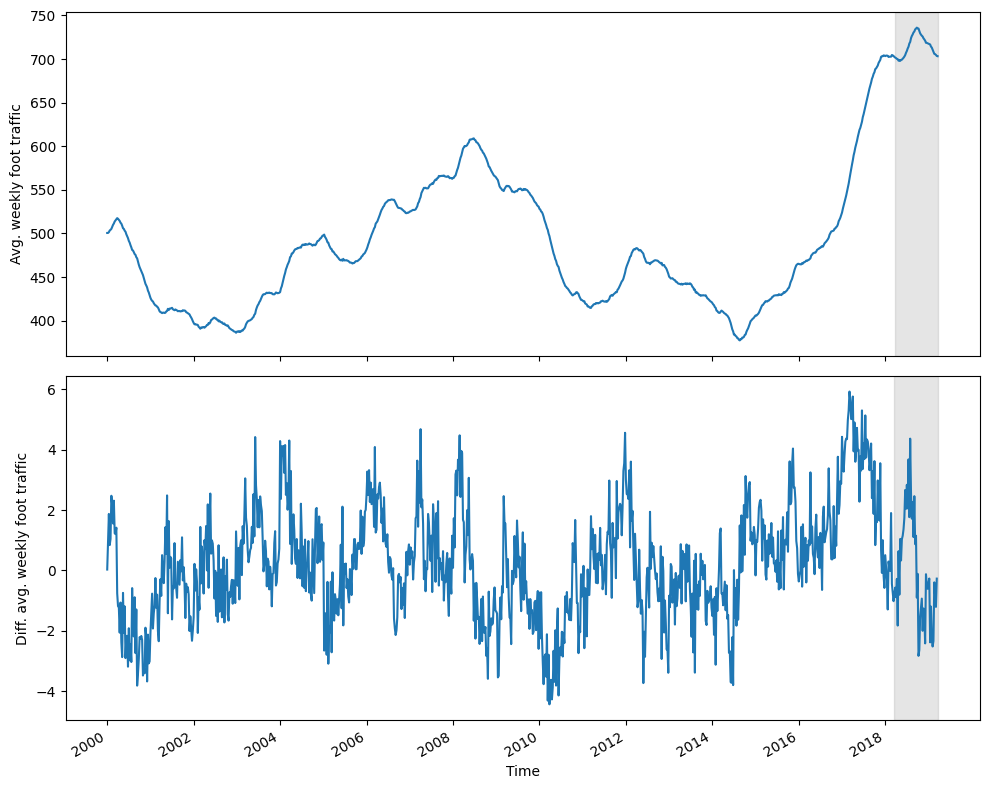

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)

ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(947, 999, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [16]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [17]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

/tmp/ipykernel_1582/2099130145.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_mean'] = pred_mean
/tmp/ipykernel_1582/2099130145.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_last_value'] = pred_last_value
/tmp/ipykernel_1582/2099130145.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


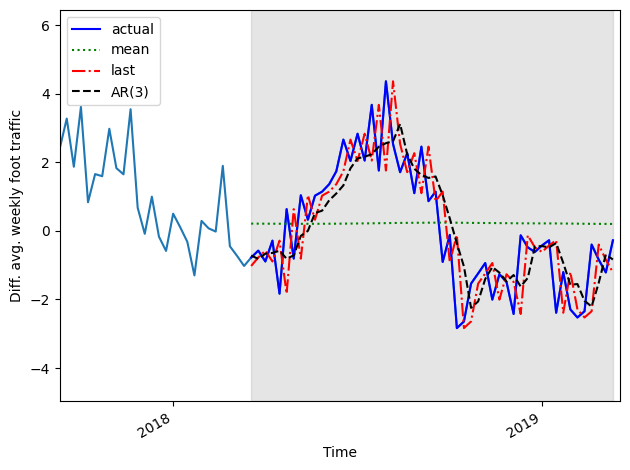

In [18]:
fig, ax = plt.subplots()

ax.plot(df_diff['foot_traffic_diff'])
ax.plot(test['foot_traffic_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

ax.axvspan(947, 998, color='#808080', alpha=0.2)

ax.set_xlim(920, 999)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

In [19]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.1079979374701447 1.448730118495964 0.9242479164116852


In [20]:
from sklearn.metrics import r2_score

r2_score(test['foot_traffic_diff'], test['pred_AR'])

0.6987306181425098

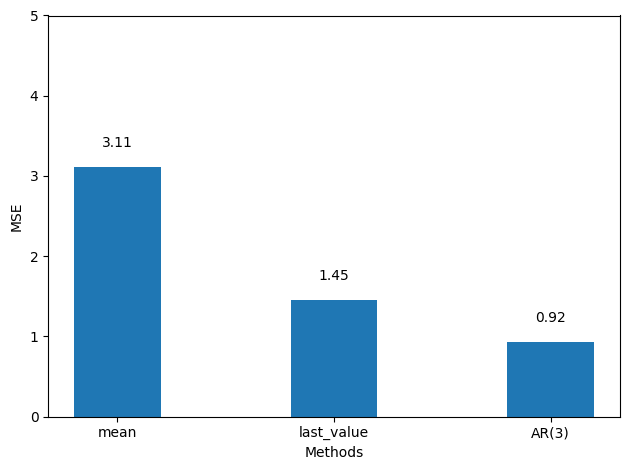

In [21]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(3)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [23]:
df['pred_foot_traffic'] = pd.Series(dtype=float)
df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum()

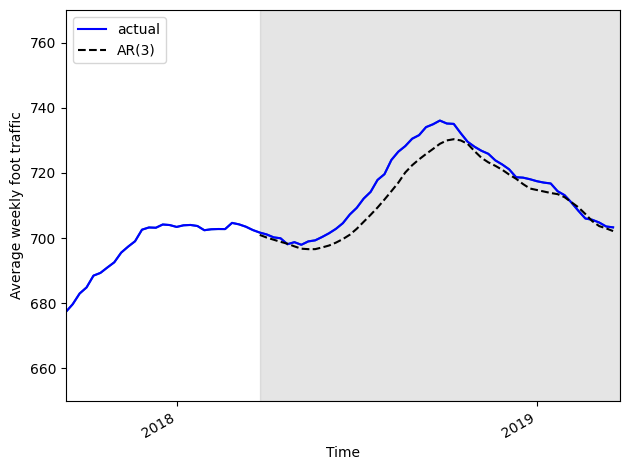

In [25]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

In [27]:
r2_score(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])

0.8605622215879156

In [28]:
from sklearn.metrics import mean_absolute_error

mae_AR_undiff = mean_absolute_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])

print(mae_AR_undiff)

3.478033559658852
